## Project 3: Web API's and NLP

### Contents

- [Data Cleaning](#cleaning)
- [Engineering Features](#engineering)
- [Chess Subreddit EDA](#chess)
- [Poker Subreddit EDA](#poker)

In [3]:
# imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

<a class="anchor" id="cleaning"></a>

### Data Cleaning

In [7]:
# read the combined csv file
df = pd.read_csv('data/combined_df.csv')

In [8]:
# display first five rows
df.head()

,Unnamed: 0,title,subreddit,selftext,created_utc
0,0,Need help to London System Players. What's the...,chess,NaN,1610545641
1,1,White to move,chess,NaN,1610545473
2,2,Start centipawn rating?,chess,I have been looking at some of Nakamura's vide...,1610544449
3,3,My Christmas project: A tiny program for graph...,chess,NaN,1610544269
4,4,chess.com Analysis Arrows,chess,So I know chess.com's computer analysis highli...,1610544181


In [9]:
# explore the type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10400 entries, 0 to 10399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   10400 non-null  int64 
 1   title        10400 non-null  object
 2   subreddit    10400 non-null  object
 3   selftext     5621 non-null   object
 4   created_utc  10400 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 406.4+ KB


In [10]:
# drop the Unnamed:0 column
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [11]:
# look for null values
df.isnull().sum()

title             0
subreddit         0
selftext       4779
created_utc       0
dtype: int64

I will skip imputing null values in the 'selftext' variable before I decide to use it as a feature in my model. 

<a class="anchor" id="engineering"></a>

### Engineering Features

In [43]:
# create a variable 'title length' counting length of each title
df['title_length'] = df['title'].str.len()

In [44]:
# sort values in the 'title length' variable
df['title_length'].sort_values()

8597       1
10023      1
7630       1
1842       1
9576       1
        ... 
6794     299
6022     300
3769     300
6793     300
5501     328
Name: title_length, Length: 10400, dtype: int64

The shortest title is 1 characer long, while the longest is 328 characters long. 

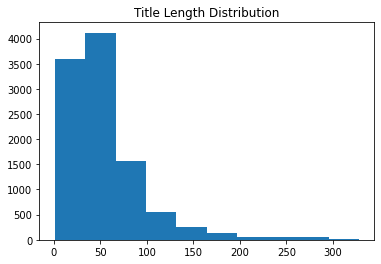

In [45]:
plt.hist(df['title_length'])
plt.title('Title Length Distribution');

Majority of the titles have length between ~40 and ~60 characters longs. 

In [46]:
# create a variable counting words in a 'title' variable
df['title_word_count'] = [len(x.split()) for x in df['title'].tolist()]

In [47]:
# sort title word count variable 
df['title_word_count'].sort_values()

6469      1
5147      1
5148      1
8782      1
5157      1
         ..
7206     60
8850     60
6431     61
10396    63
6062     66
Name: title_word_count, Length: 10400, dtype: int64

The shortest titles have one word, while the longest titles have 66 words. 

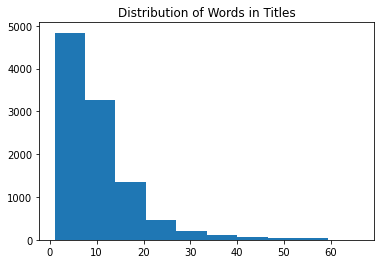

In [36]:
plt.hist(df['title_word_count'])
plt.title('Distribution of Words in Titles');

Looks like majority of titles range between ~1 and ~5 words.

In [37]:
# earliest timestamp of posted titles
df['created_utc'].min()

1601184366

The earlier datapoint is September 27, 2020. The data is fairly recent. 

In [40]:
# latest timestamp of posted titles
df['created_utc'].max()

1610546083

The latest datapoint is January 13, 2021. 

In [38]:
# # save to csv
# df.to_csv('data/clean_combined.csv', index = False)

<a class="anchor" id="chess"></a>

### Chess subreddit EDA 

In [105]:
# create a dataframe from the chess subreddit only
df_chess = df.loc[df['subreddit'] == 'chess']

In [106]:
# sort title length related to the chess subreddit only 
df_chess['title'].str.len().sort_values()

1842      1
2772      2
664       2
669       2
456       2
       ... 
2785    296
44      296
1071    296
189     298
3769    300
Name: title, Length: 5000, dtype: int64

In [107]:
df_chess['title']

0       Need help to London System Players. What's the...
1                                           White to move
2                                 Start centipawn rating?
3       My Christmas project: A tiny program for graph...
4                               chess.com Analysis Arrows
                              ...                        
4995              Mate in 9. Look for the back and forth!
4996                                   why did he resign?
4997    Here's an interactive guide I just wrote for a...
4998    I chose one of my losses at random and an anal...
4999    I chose one of my losses at random and an anal...
Name: title, Length: 5000, dtype: object

In [108]:
df_chess['title_length'].mean()

61.9124

Length of the shortest title within the chess subreddit is one character and length of the longest title is 300 characters.  

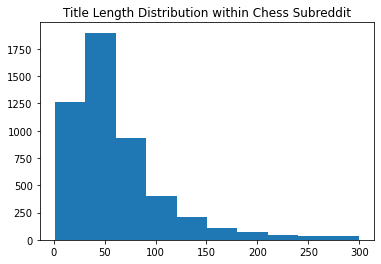

In [83]:
plt.hist(df_chess['title_length'])
plt.title('Title Length Distribution within Chess Subreddit')
plt.savefig('chess_title_length');

Majority of the titles contain between ~40 and ~60 characters.

In [84]:
# create a datframe of number of words in 'title' within the chess subreddit
chess_word_count = pd.DataFrame([len(x.split()) for x in df_chess['title'].tolist()])

In [85]:
chess_word_count.sort_values(by = 0)

,0
2938,1
3256,1
2772,1
4666,1
3049,1
...,...
2306,59
2869,59
4335,59
3901,59


In the chess subreddit, shortest title consisted of one word and the longest consisted of 60 words.

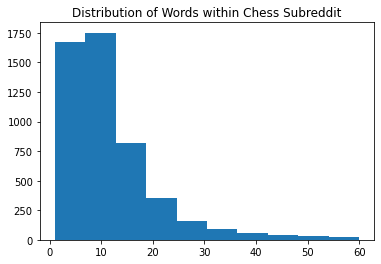

In [75]:
plt.hist(chess_word_count[0])
plt.title('Distribution of Words within Chess Subreddit')
plt.savefig('chess_words');

Most of the title contain between ~1 and 11 words. 

#### Countvectorizing the Chess Titles

In [76]:
# instantiate CountVectorizer (used max features 500)
cvect = CountVectorizer(stop_words = 'english', ngram_range = (2,2), max_features = 500)

In [77]:
# count-vectorize the title column
title_vect = cvect.fit_transform(df_chess['title'])

In [78]:
# make a dataframe
df_vect = pd.DataFrame(title_vect.toarray(), columns = cvect.get_feature_names())

In [90]:
# sort values in a vectorized dataframe and show 15 most commong words
df_vect.sum().sort_values(ascending = False).head(20)

chess com         302
white play         90
white mate         79
chess set          67
new chess          61
black play         60
play win           52
mate white         50
queen gambit       46
blitz game         44
magnus carlsen     41
white win          39
playing chess      36
black mate         36
chess board        34
play chess         31
game white         30
game played        29
game black         28
queens gambit      25
dtype: int64

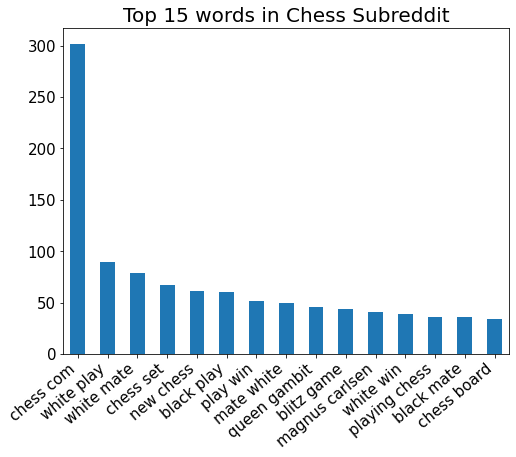

In [67]:
# plot a bar chart of top 15 words
plt.figure(figsize = (8, 6))
df_vect.sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('Top 15 words in Chess Subreddit', fontsize = 20)
plt.xticks(ha='right', rotation=40, fontsize=15)
plt.yticks(fontsize = 15)
plt.savefig('chess_top_words');

Most used words in the chess subreddit are: chess, game, white, mate, black, play, com, just, win, best, queen, checkmate, playing, lichess, played. 

In [219]:
# shows first 20 titles containing the word 'chess'
[title for title in df_chess['title'] if 'chess' in title.lower()][:20]

['My Christmas project: A tiny program for graphing playtime and some other stats from Chess.com',
 'chess.com Analysis Arrows',
 'Wooden chess set',
 'My Christmas project: A tiny program for graphing playtime and some other stats from Chess.com',
 "What's your favourite piece in chess?",
 'Is there a chess database containing all official matches ever played?',
 'After using chess.com for 1 day, I do my best check mate yet, anyone what this is called or if it has a name?',
 'What chess opening book is betted?',
 'Lichess (Accuracy % vs AI)',
 'Man i was almost 1400 and took a break from playing chess to work on school more. i was 1390ish and then boom im now 1290.',
 'Problem with Lesson on Chess.com',
 'Problem found on Chess.com',
 'Thanks to @gothamchess \'s video, I got this position today. I am 800 rated and also my highest accuracy since I started playing 6 months back, "98.9".',
 'If Chess Was An Anime!',
 'Why does lichess feel so smooth compared to chess24 and chess com?',
 

#### Sentiment Analysis of Chess Titles

In [119]:
# create textblob objects of the 'title' in the chess dataframe
sentiment_objects_chess = [TextBlob(i) for i in df_chess['title']]

In [122]:
# Create list of polarity values
sentiment_values_chess = [[i.sentiment.polarity, str(i)] for i in sentiment_objects_chess]

In [125]:
# Create dataframe containing the polarity value and title text
sentiment_df_chess = pd.DataFrame(sentiment_values_chess, columns = ['polarity', 'title'])

In [223]:
# display top 10 with rows with positive sentiment
sentiment_df_chess.sort_values(by = 'polarity', ascending = False).head(10)

,polarity,title
0,1.0,Need help to London System Players. What's the...
1419,1.0,Best chess discord ever!
3643,1.0,Why was this best?
1604,1.0,"Whites move, what’s the best way to approach t..."
3802,1.0,"Why does it say Nf7 is best, but if I try that..."
3833,1.0,Best place to play online?
1526,1.0,Beautiful Symmetric Mate in 1!
1509,1.0,Spot the best move which I played
1507,1.0,Can you explain why was that move the best opt...
3869,1.0,Why is D5 considered a blunder and D6 best?


In [215]:
# display bottom 10 with rows with negative sentiment
sentiment_df_chess.sort_values(by = 'polarity', ascending = False).tail(10)

,polarity,title
1404,-1.0,Absolutely insane mate in 2
1299,-1.0,Chess.com app is horrible
2483,-1.0,the worst played chess ending with 4 missed ch...
4572,-1.0,Life or death chess. Insane pressure.
519,-1.0,Is there a program or engine that can find the...
3895,-1.0,Chess is just so fucking boring tbh. Lost majo...
2702,-1.0,Why am I so terrible at chess?
479,-1.0,A disgusting checkmate I got with the king on e5
1862,-1.0,Insane Stockfish Line: Mate in 6
4553,-1.0,Life or death chess. Insane pressure.


In [145]:
# Remove polarity values equal to zero to better visualize values
sentiment_df_chess = sentiment_df_chess[sentiment_df_chess.polarity != 0]

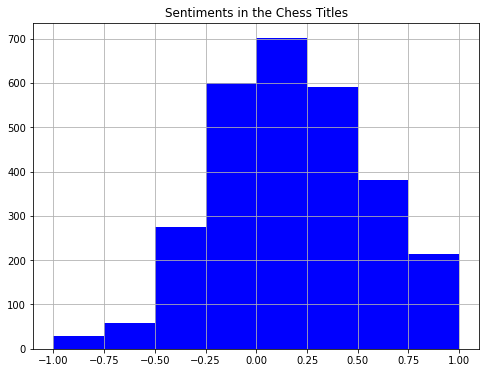

In [152]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df_chess.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="blue")

plt.title("Sentiments in the Chess Titles")
plt.savefig('chess_sentiment');

After removing titles with 0 polarity, it looks like majority of the titles have -0.25 to 0.5 polarity. 

<a class="anchor" id="poker"></a>

### Poker subreddit EDA

In [109]:
# create a dataframe from poker subreddit only
df_poker = df.loc[df['subreddit'] == 'poker']

In [110]:
# sort title length related to the poker subreddit only 
df_poker['title'].str.len().sort_values()

8427       1
10023      1
6748       1
9576       1
7630       1
        ... 
7206     298
6794     299
6793     300
6022     300
5501     328
Name: title, Length: 5400, dtype: int64

In the poker subreddit, the shortest title consisted of 1 character, while the longest title consisted of 328 characters. 

In [111]:
df_poker['title_length'].mean()

48.82259259259259

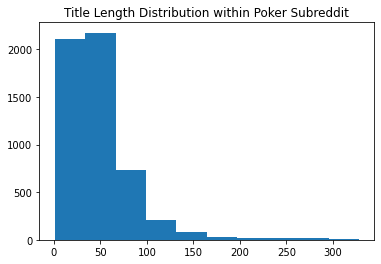

In [95]:
plt.hist(df_poker['title_length'])
plt.title('Title Length Distribution within Poker Subreddit')
plt.savefig('poker_title_length');

In the poker subreddit, majority of the titles are between ~1 and ~60 characters long. 

In [96]:
# create a datframe of number of words in 'title' within the poker subreddit
poker_word_count = pd.DataFrame([len(x.split()) for x in df_poker['title'].tolist()])

In [97]:
poker_word_count.sort_values(by = 0)

,0
5076,1
3200,1
2017,1
96,1
2018,1
...,...
2206,60
3850,60
1431,61
5396,63


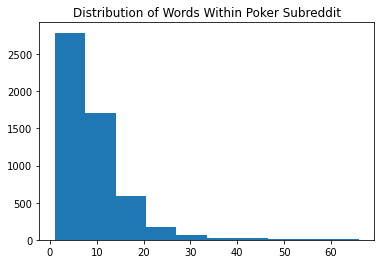

In [98]:
plt.hist(poker_word_count[0])
plt.title('Distribution of Words Within Poker Subreddit')
plt.savefig('poker_words');

Majority of the titles are made of 1-6 words within the poker subreddit.

#### Countvectorizing the Poker Titles

In [99]:
# instantiate CountVectorizer (used max features 500)
cvect_poker = CountVectorizer(stop_words = 'english', ngram_range = (2,2), max_features = 500)

In [100]:
# count-vectorize the title column
title_vect_poker = cvect_poker.fit_transform(df_poker['title'])

In [101]:
# make a dataframe
df_vect_poker = pd.DataFrame(title_vect_poker.toarray(), columns = cvect_poker.get_feature_names())

In [104]:
# sort values in a vectorized dataframe and show 15 most commong words
df_vect_poker.sum().sort_values(ascending = False).head(20)

online poker       117
home game           58
live poker          52
cash game           49
global poker        39
high stakes         38
hold em             38
hand analysis       37
bad beat            36
doug polk           34
sheldon adelson     34
hand review         33
final table         31
cash games          31
poker online        30
daniel negreanu     30
play poker          29
id pro              28
pkv games           27
gg poker            27
dtype: int64

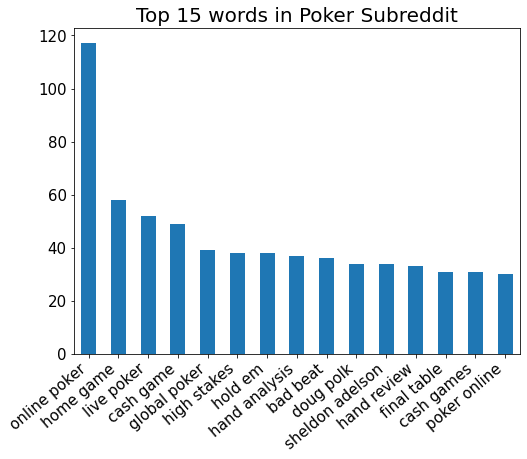

In [103]:
# plot a bar chart of top 15 words
plt.figure(figsize = (8, 6))
df_vect_poker.sum().sort_values(ascending = False).head(15).plot(kind = 'bar')
plt.title('Top 15 words in Poker Subreddit', fontsize = 20)
plt.xticks(ha='right', rotation=40, fontsize=15)
plt.yticks(fontsize = 15)
plt.savefig('poker_top_words');

Most used words in the chess subreddit are: poker, online, hand, play, game, live, vs, best, players, pokerstars, games, cash, playing, player, tournament


In [217]:
# shows first 20 titles containing the word 'poker'
[title for title in df_poker['title'] if 'poker' in title.lower()][:20]

['Pokerstars ZOOM IN PLAYCHIP (100000, 200000) vs REAL MONEY',
 'Starting poker part-time career in my 40s, give me the real truth',
 'How to play Poker?',
 'VPN GGpoker?',
 'Does the Borgata in Atlantic City have live poker TOURNAMENTS, not cash games?',
 'Looking to build your bankroll? The Track is a fully transparent club on Pokerrr 2. .25/.50 NLHE',
 'Trusted online poker?',
 'Anyone ever had a problem with not receiving win funds on betonline poker',
 'The best poker play in the world',
 'Come join BASTARDS club, code R2V9Z! THE #1 Trusted Club since 2019 - with the best player promos available anywhere on Pokerrrr 2 app! Come join today',
 'Pokerstars cardschat pw?',
 '5 card poker app?',
 'GLOBAL POKER isTHIRD WORLD MALAYSIA scamming trash.....its run like a ponzi scheme...',
 'Best research materials and/or theories for improving my poker game?',
 'Poker Tournaments !!',
 'Sheldon Adelson, Biggest Online Poker Foe, Dies at 87',
 'Online poker opponent Sheldon Adelson has died'

#### Sentiment Analysis of Poker Titles

In [133]:
# create textblob objects of the 'title' in the poker dataframe
sentiment_objects_poker = [TextBlob(i) for i in df_poker['title']]

In [134]:
# Create list of polarity values
sentiment_values_poker = [[i.sentiment.polarity, str(i)] for i in sentiment_objects_poker]

In [135]:
# Create dataframe containing the polarity value and title text
sentiment_df_poker = pd.DataFrame(sentiment_values_poker, columns = ['polarity', 'title'])

In [136]:
# display top 10 with rows with positive sentiment
sentiment_df_poker.sort_values(by = 'polarity', ascending = False).head(10)

,polarity,title
4344,1.0,What is the best Bitcoin withdrawal method for...
4937,1.0,Best hand to crack aces
3852,1.0,"WA state, best loophole with bitcoin to go aro..."
5006,1.0,Best way to study a book
3108,1.0,Best platform for iPad experience?
3109,1.0,The best flop in PLO8 I’ve ever had.
3120,1.0,Come check out my awesome stream layout!! Ask ...
2125,1.0,What are some of the best online casinos now?
3138,1.0,Best rake deals at the moment?
5350,1.0,Best payout poker club yet


In [137]:
# display bottom 10 with rows with negative sentiment
sentiment_df_poker.sort_values(by = 'polarity', ascending = False).tail(10)

,polarity,title
5292,-1.0,what is the worst argument or fight you witnes...
1334,-1.0,I just won the biggest pot of my life in casin...
4281,-1.0,Horribly played hand reflection
3299,-1.0,What's the worst you've ever been unintentiona...
5313,-1.0,Worst beat I’ve had in a while ..
1492,-1.0,The Horrible Graphics on High-stakes Poker 202...
3353,-1.0,When researching penguins gets boring
4378,-1.0,The worst hand in poker
1394,-1.0,Advice for after a terrible session
2947,-1.0,Insane laydown at 2018 Colossus FT


In [139]:
# Remove polarity values equal to zero to better visualize values
sentiment_df_poker = sentiment_df_poker[sentiment_df_poker.polarity != 0]

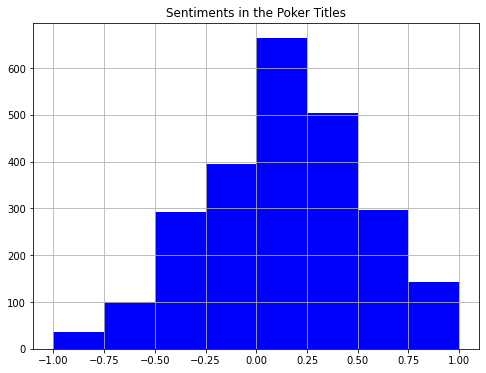

In [156]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df_poker.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="blue")

plt.title("Sentiments in the Poker Titles")
plt.savefig('poker_sentiment')

After removing titles that have polarity equal to 0, it seems that majority of the titles are between 0 and 0.5 polarity. 